# NLP Capstone Project - Movie Review - Sentiment Analysis -  Classify the sentiment of sentences from the Rotten Tomatoes dataset
## Developing Machine Learning Models using pre-trained GLoVe Word embeddings as feature extraction / representation

![](https://cdn.steemitimages.com/DQmQZCf7ME7Haj3X3MzXtG8R8JtGmTpuh5NXDSd3wKueva7/rottentomatoes.png)

![ML](https://juststickers.in/wp-content/uploads/2017/04/machine-learning.png)

![W2v](https://newvitruvian.com/images/term-vector-word2vec-4.png)

Moving one from EDA and Machine Learning models with TF - IDF Feature EXtraction / Representation, another feature representation technique is to convert the words from inside the phrases from the movies reviews into dense vectors. In particular the ML models will be developed in conjunction with Word Embeddings as feature representation.

As Word Embeddings already pre-trained Word Embeddings will be used from [Stanford NLP](https://nlp.stanford.edu/projects/glove/).

At first, There must be mention again that after EDA and ML models with TF / IDF again an odd conclusion was made. The dataset of this competition turned to have some unique features. we have only phrases as data. And a phrase can contain a single word. And one punctuation mark can cause phrase to receive a different sentiment. Also assigned sentiments can be strange. This means several things:

- using stopwords can be a bad idea, especially when phrases contain one single stopword;
- puntuation could be important, so it should be used;
- ngrams are necessary to get the most info from data;
- using features like word count or sentence length won't be useful;

** This thought will be enhanced later with my anomaly detection insights **

## Loading Main Libraries

In [ ]:
import pandas as pd

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk

import seaborn as sns

### load the dataset

In [ ]:
df = pd.read_csv("../input/train.tsv", sep="\t")

df_test = pd.read_csv("../input/test.tsv", sep="\t")

### Preview

In [ ]:
df.head(10)

In [ ]:
df_test.head(10)

### Thoughts before training ML models
Here are couple of instances where punctuations appeared to be predictive. So if we "cleanedup" the data in the name of data preparation some predictiveness will be lost.

In [ ]:
example = df[(df['PhraseId'] >= 0) & (df['PhraseId'] <= 2)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

In [ ]:
example = df[(df['PhraseId'] >= 517) & (df['PhraseId'] <= 518)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

Below another example that the appearance punctuation symbol "," is important

In [ ]:
example = df[(df['PhraseId'] >= 68) & (df['PhraseId'] <= 69)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

Below another example that the appearance punctuation symbol "!" is important

In [ ]:
example = df[(df['PhraseId'] >= 10737) & (df['PhraseId'] <= 10738)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

Another strange thing that I discovered is that there are phrases with a single word only and if they disappear at the following phrases the sentiment changes.

In [ ]:
example = df[(df['PhraseId'] >= 22) & (df['PhraseId'] <= 24)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

print()

print(example["Phrase"].values[2], " - Sentiment:", example["Sentiment"].values[2])

In [ ]:
example = df[(df['PhraseId'] >= 46) & (df['PhraseId'] <= 47)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

As you can see sentence id denotes a single review with the phrase column having the entire review text as an input instance followed by random suffixes of the same sentence to form multiple phrases with subsequent phrase ids. This repeats for every single new sentence id (or new review per se). The sentiment is coded with 5 values 0= Very negative to 4=Very positive and everything else in between.

A quick glance will show you that the data is a little weird for a sentiment corpus:

- Phrases of sentences are** chopped up compeltely randomly**. So logic like sentence tokenization based on periods or punctuations or something of that sort doesn't apply
- Certain phrases are **with one single word!**.
- For some phrases inclusion of a punctuation like a comma or a full stop changes the sentiment from say 2 to 3 i.e neutral to positive.
- Some phrases **starts** with a punctuation like a **backquote**.
- Some phrases **end** with a **punctuation**
- There are some ** weird ** words such as ** -RRB-,  -LRB- **

All these weird aspects of this dataset, can be helpful and may be predictive. Afterall, we are looking for patterns in data. Therefore, it would be easier for us to engineer features, I mean apart from the text features that can be extracted from the corpus.

So, after all this train of thought, let us move on to Machine Learning and Predictive Models.

_________________________

## Word to feature Extraction with pre-trained Word Embeddings
![w2v2](https://cdn-images-1.medium.com/max/1600/1*jpnKO5X0Ii8PVdQYFO2z1Q.png)

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Word Embeddings originates from the idea of generating distributed representations. Intuitively, there is some dependence of one word on the other words. The words in context of this word would get a greater share of this dependence. In one hot encoding representations, all the words are independent of each other, as mentioned earlier.

Word Embeddings are vector representations of a particular word. Word Embeddings is a method to construct such an embedding. It can be obtained using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words. [source](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa).

To get Word Embeddings they will be downloaded from Stanford NLP GloVe: **Global Vectors for Word Representation**. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space [source](https://nlp.stanford.edu/projects/glove/).

So we continue with the download of the GLoVe embeddings, The embedding size of 300 will be used for increased expressibility.

In [ ]:
#download GLoVe Embeddings

import os,requests

def download(url):
    get_response = requests.get(url,stream=True)
    file_name  = url.split("/")[-1]
    with open(file_name, 'wb') as f:
        for chunk in get_response.iter_content(chunk_size=1024):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
        

download("http://nlp.stanford.edu/data/glove.6B.zip")
        


### Export the GLoVe zip file.

In [ ]:
# Export the GLoVe zip file.

import zipfile

with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
os.listdir()

### Reading the GLoVe embedding txt file

In [ ]:
embedding_dim = 300
filename = 'glove.6B.'+ str(embedding_dim) +'d.txt'

glove_w2v_embeddings_index = dict()
f = open(filename, "r", encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_w2v_embeddings_index[word] = coefs
f.close()

### Averaging glove embeddings
Since each word is a vector with size of 300. We have phrases that have different number of words. To solve this issue all the word vectors per phrase will be averaged to reduce a phrase with different words to a averaged word vector with dimension of 300.

In [ ]:
sentences = df['Phrase'].values
major_sent = []

for sent in sentences:
    
    temp_sent = []
    
    for word in sent.split(" "):    
        
        if word in glove_w2v_embeddings_index:
            temp = glove_w2v_embeddings_index['word']
        else:
            temp = np.zeros(embedding_dim)

        temp_sent.append(temp)
    
    temp_sent = np.mean(temp_sent, axis=0)
    major_sent.append(temp_sent)

In [ ]:
print("Train Set dimensions after averaging Word Embeddings:")
print(np.shape(major_sent))

## Machine Learning Techiniques for Multiclass Sentiment Analysis

The Machine Learning models that will be deployed is the following:
 - **Regression Models**: 
     - LogisticRegression
 - **CART Models**: 
     - DecisionTreeClassifier
     - ExtraTreeClassifier
 - **Bagging Trees**: 
     - ExtraTreesClassifier
     - RandomForestClassifier 
 - **SVM Models**: 
     - LinearSVC 
 - **Naive Bayes Models**: 
     - BernoulliNB
     - MultinomialNB
 - **Boosting Trees**: 
     - Adaboost Classifier
     - Extreme Gradient Boosting, XGBoost 
 - **Lazy Classifiers**: 
     - KNeighborsClassifier
 
 Since the competion evaluates the models based on accuracy then the models will be evaluated based on accuracy and because the dataset is unbalanced (based on its EDA) us a secondary statistical evaluation metric I will use the F1 score.
 
 The train set will be split in train and validation sets with ratio **80:20** .
 
 For all the ML models the random state will be set to 42 in order to the models be reproducable and create the same results in every run.
 
 Finally as a benchmark model, due to the fact that XGBoost is a state of the art model that is widely used in Machine Learning [source](https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html), it will be used as benchmark and the rest of the Machine Learning models will be compared to its performance

In [ ]:
X = major_sent
y = df.Sentiment.values

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import time

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)


In [ ]:
ml_default_performance_metrics_df = pd.DataFrame(columns=['accuracy','F1-score','training-time'], index=['LogisticRegression', 'DecisionTreeClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'LinearSVC', 'BernoulliNB', 'AdaboostClassifier', 'XGB', 'KNeighborsClassifier'])


### Multinomial Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

start_time = time.time()

clf_logistic_regression = LogisticRegression(multi_class='ovr', solver='sag', random_state=42)
clf_logistic_regression.fit(xtrain, ytrain)
predictions = clf_logistic_regression.predict(xvalid)

print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)


ml_default_performance_metrics_df.loc['LogisticRegression']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['LogisticRegression']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['LogisticRegression']['F1-score'] = f1_score(yvalid, predictions, average='macro')


print()
print("elapsed time: ", time.time() - start_time)
print()

### DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()
    
print()
print("Evaluation of DecisionTreeClassifier, with train-test split:")

clf_DecisionTreeClassifier = DecisionTreeClassifier(random_state=42)
clf_DecisionTreeClassifier.fit(xtrain, ytrain)
predictions = clf_DecisionTreeClassifier.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)


ml_default_performance_metrics_df.loc['DecisionTreeClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['DecisionTreeClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['DecisionTreeClassifier']['F1-score'] = f1_score(yvalid, predictions, average='macro')

print()
print("elapsed time: ", time.time() - start_time)
print()

### ExtraTreeClassifier

In [ ]:
from sklearn.tree import ExtraTreeClassifier

start_time = time.time()
    
print()
print("Evaluation of ExtraTreeClassifier with train-test split:")

clf_ExtraTreeClassifier = ExtraTreeClassifier()
clf_ExtraTreeClassifier.fit(xtrain, ytrain)
predictions = clf_ExtraTreeClassifier.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

ml_default_performance_metrics_df.loc['ExtraTreeClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['ExtraTreeClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['ExtraTreeClassifier']['F1-score'] = f1_score(yvalid, predictions, average='macro')

print()
print("elapsed time: ", time.time() - start_time)
print()

### ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

start_time = time.time()
    
print()
print("Evaluation of ExtraTreesClassifier with train-test split:")

clf_ExtraTreesClassifier = ExtraTreesClassifier(n_estimators=10, random_state=42)
clf_ExtraTreesClassifier.fit(xtrain, ytrain)
predictions = clf_ExtraTreesClassifier.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['ExtraTreesClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['ExtraTreesClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['ExtraTreesClassifier']['F1-score'] = f1_score(yvalid, predictions, average='macro')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time: ", time.time() - start_time)
print()

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
    
print()
print("Evaluation of RandomForestClassifier with train-test split:")

clf_RandomForestClassifier = RandomForestClassifier(n_estimators = 10, random_state=42)
clf_RandomForestClassifier.fit(xtrain, ytrain)
predictions = clf_RandomForestClassifier.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['RandomForestClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['RandomForestClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['RandomForestClassifier']['F1-score'] = f1_score(yvalid, predictions, average='macro')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time: ", time.time() - start_time)
print()

### LinearSVC (ovr)

In [ ]:
from sklearn.svm import LinearSVC

start_time = time.time()
    
print()
print("Evaluation of LinearSVC, multi_class='ovr', with train-test split:")

clf_LinearSVC = LinearSVC(multi_class='ovr', random_state=42)
clf_LinearSVC.fit(xtrain, ytrain)
predictions = clf_LinearSVC.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['LinearSVC']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['LinearSVC']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['LinearSVC']['F1-score'] = f1_score(yvalid, predictions, average='macro')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time: ", time.time() - start_time)
print()

### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB

start_time = time.time()
    
print()
print("Evaluation of BernoulliNB with train-test split:")

clf_BernoulliNB = BernoulliNB()
clf_BernoulliNB.fit(xtrain, ytrain)
predictions = clf_BernoulliNB.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['BernoulliNB']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['BernoulliNB']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['BernoulliNB']['F1-score'] = f1_score(yvalid, predictions, average='macro')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time: ", time.time() - start_time)
print()

### MultinomialNB - GaussianNB
 I can not use GaussianNB and MultinomialNB because the averaged word embeddings contain and negative numbers and both models can not fit with negative data.

### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

start_time = time.time()
    
print()
print("Evaluation of Adaboost with train-test split:")

clf_adaboost = AdaBoostClassifier(random_state=42)
clf_adaboost.fit(xtrain, ytrain)
predictions = clf_adaboost.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy score", accuracy_score(yvalid, predictions))
print("missclass score", 1 - accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['AdaboostClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['AdaboostClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['AdaboostClassifier']['F1-score'] = f1_score(yvalid, predictions, average='macro')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)


### storing performance results:


print()
print("elapsed time: ", time.time() - start_time)
print()

### Xgboost

In [ ]:
import xgboost as xgb

start_time = time.time()

clf_xgb = xgb.XGBClassifier(objective = 'multi:softmax', seed=42)
clf_xgb.fit(np.array(xtrain), ytrain)
predictions = clf_xgb.predict(np.array(xvalid))

print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['XGB']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['XGB']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['XGB']['F1-score'] = f1_score(yvalid, predictions, average='macro')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time: ", time.time() - start_time)
print()

### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

clf_knn = KNeighborsClassifier()
clf_knn.fit(xtrain, ytrain)
predictions = clf_knn.predict(xvalid)

print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['KNeighborsClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['KNeighborsClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['KNeighborsClassifier']['F1-score'] = f1_score(yvalid, predictions, average='macro')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time: ", time.time() - start_time)
print()

### Summarizing ML Classifiers based on their accuracy with TF - IDF as Feature Extraction

In [56]:
ml_default_performance_metrics_df.sort_values(by="accuracy", ascending=False)

,accuracy,F1-score,training-time
ExtraTreesClassifier,0.505511,0.174245,8.51305
AdaboostClassifier,0.505094,0.156878,126.755
ExtraTreeClassifier,0.504998,0.175626,1.28889
DecisionTreeClassifier,0.504966,0.170238,7.9425
RandomForestClassifier,0.504485,0.167113,4.41823
LogisticRegression,0.501057,0.133521,58.1898
LinearSVC,0.501057,0.133521,943.937
XGB,0.501057,0.133521,504.153
KNeighborsClassifier,0.459278,0.232606,431.269
BernoulliNB,0.0925926,0.0472105,1.22242


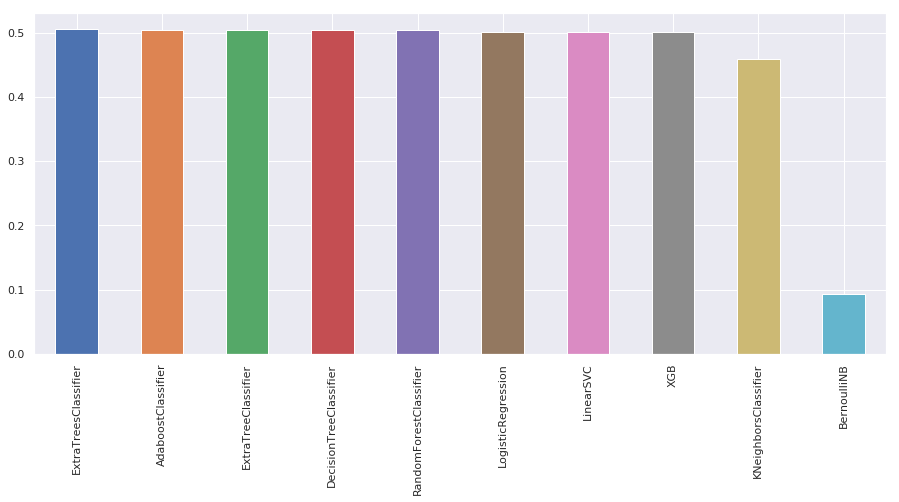

In [57]:
sns.set(rc={'figure.figsize':(15.27,6.27)})
ml_default_performance_metrics_df.sort_values(by="accuracy", ascending=False).accuracy.plot(kind="bar")

### Summarizing ML Classifiers based on their F1-score with TF - IDF as Feature Extraction

In [58]:
ml_default_performance_metrics_df.sort_values(by="F1-score", ascending=False)

,accuracy,F1-score,training-time
KNeighborsClassifier,0.459278,0.232606,431.269
ExtraTreeClassifier,0.504998,0.175626,1.28889
ExtraTreesClassifier,0.505511,0.174245,8.51305
DecisionTreeClassifier,0.504966,0.170238,7.9425
RandomForestClassifier,0.504485,0.167113,4.41823
AdaboostClassifier,0.505094,0.156878,126.755
LogisticRegression,0.501057,0.133521,58.1898
LinearSVC,0.501057,0.133521,943.937
XGB,0.501057,0.133521,504.153
BernoulliNB,0.0925926,0.0472105,1.22242


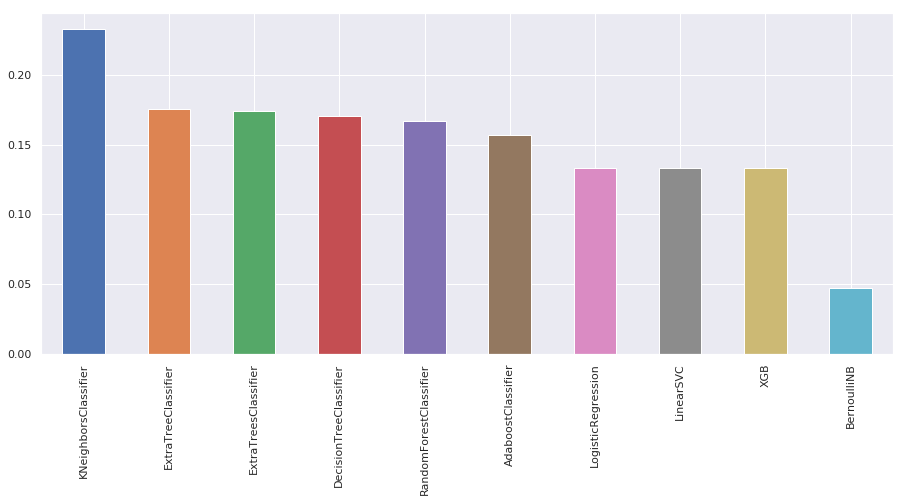

In [59]:
sns.set(rc={'figure.figsize':(15.27,6.27)})
ml_default_performance_metrics_df.sort_values(by="F1-score", ascending=False)["F1-score"].plot(kind="bar")

### Summarizing ML Classifiers based on their training fitting time with TF - IDF as Feature Extraction

In [60]:
ml_default_performance_metrics_df.sort_values(by="training-time", ascending=False)

,accuracy,F1-score,training-time
LinearSVC,0.501057,0.133521,943.937
XGB,0.501057,0.133521,504.153
KNeighborsClassifier,0.459278,0.232606,431.269
AdaboostClassifier,0.505094,0.156878,126.755
LogisticRegression,0.501057,0.133521,58.1898
ExtraTreesClassifier,0.505511,0.174245,8.51305
DecisionTreeClassifier,0.504966,0.170238,7.9425
RandomForestClassifier,0.504485,0.167113,4.41823
ExtraTreeClassifier,0.504998,0.175626,1.28889
BernoulliNB,0.0925926,0.0472105,1.22242


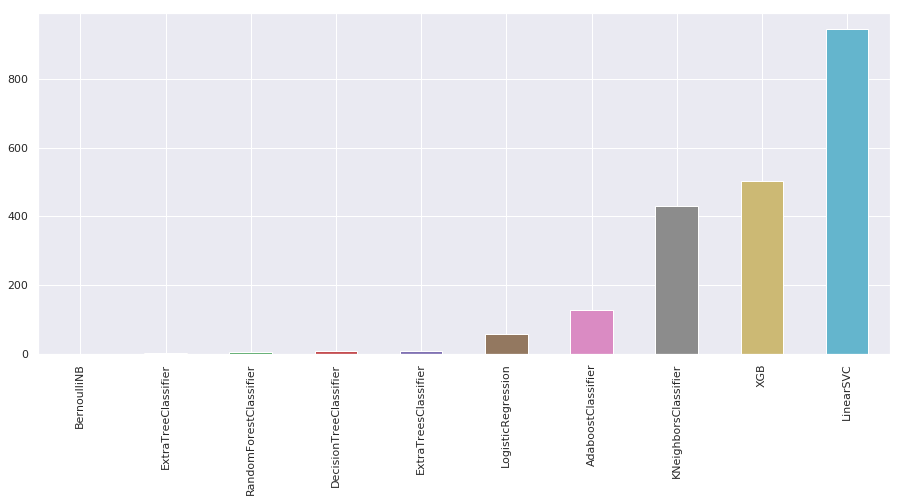

In [61]:
sns.set(rc={'figure.figsize':(15.27,6.27)})
ml_default_performance_metrics_df.sort_values(by="training-time", ascending=True)["training-time"].plot(kind="bar")

## ML Predictions over the Test Set using the Top 3 ML models
After all these experiments there is one conclusion, We cannot combine and use together averages word embeddings and Machine Learning models for this dataset. All ML models performed very bad against themselves and against XGBoost. They missclassify most of cases as class #2 type neutral class and their accuracy is close to 0.5 which means that they fail to classify half of the cases from the validation set and F1-score is even below 0.5 which validates the high missclassification.

The Top performed ML models in both accuracy, training time and F1-score combined with averaged word embeddings per phrase are the following: 
- ExtraTree
- ExtraTrees
- DecisionTrees
- Random Forest

There is no need for ensemble models using the statistical mode over the predicted class neither the tuning cause they will not improve dramatically the models' performance.

So we will move on by producing the predictions over the test set with the top 4 ML models and create submission csv files.

In [62]:
#averaging word embeddings for the test set

df_test = pd.read_csv("../input/test.tsv", sep="\t")
sentences_test = df_test.Phrase.values

major_sent_test = []

for sent in sentences_test:
    
    temp_sent = []
    
    for word in sent.split(" "):    
        
        if word in glove_w2v_embeddings_index:
            temp = glove_w2v_embeddings_index['word']
        else:
            temp = np.zeros(embedding_dim)

        temp_sent.append(temp)
    
    temp_sent = np.mean(temp_sent, axis=0)
    major_sent_test.append(temp_sent)

test_vectorized = major_sent_test

# producing predictions over the test set with the top 4 ML models

predictions_default_extra_trees = clf_ExtraTreesClassifier.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_default_extra_trees
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_extra_trees.csv',index=False)

predictions_default_extra_tree = clf_ExtraTreeClassifier.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_default_random_forest
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_random_forest.csv',index=False)

predictions_default_decision_tree = clf_DecisionTreeClassifier.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_default_random_forest
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_random_forest.csv',index=False)

predictions_default_decision_tree = clf_RandomForestClassifier.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_default_random_forest
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_random_forest.csv',index=False)

## Summary
The combination of Word Embeddings and Machine Learning models does not seem to work. **All models** to fit on the data. There is no understanding why this is happening and all models presents accuracy close to 0.5. Even ensembling predictions using the statistical mode was not produced because there no need to due to these unsatisfactory results. It is believed that ML models in general do not pocess the ability to fit on the data. So the time for Deep Learning comes to see if has the power to fit better than Machine Learning.
___________________

___________________________________________________________________